# CNN using Tensorflow Keras on MRI Image Data

## Data Use Agreements
The data used for this project were provided in part by OASIS and ADNI.

OASIS-3: Principal Investigators: T. Benzinger, D. Marcus, J. Morris; NIH P50 AG00561, P30 NS09857781, P01 AG026276, P01 AG003991, R01 AG043434, UL1 TR000448, R01 EB009352. AV-45 doses were provided by Avid Radiopharmaceuticals, a wholly owned subsidiary of Eli Lilly.

Data collection for this project was done through the Alzheimer's Disease Neuroimaging Initiative (ADNI) (National Institutes of Health Grant U01 AG024904) and DOD ADNI (Department of Defense award number W81XWH-12-2-0012). ADNI is funded by the National Institute on Aging, the National Institute of Biomedical Imaging and Bioengineering, and through generous contributions from the following: AbbVie, Alzheimer’s Association; Alzheimer’s Drug Discovery Foundation; Araclon Biotech; BioClinica, Inc.; Biogen; Bristol-Myers Squibb Company; CereSpir, Inc.; Cogstate; Eisai Inc.; Elan Pharmaceuticals, Inc.; Eli Lilly and Company; EuroImmun; F. Hoffmann-La Roche Ltd and its affiliated company Genentech, Inc.; Fujirebio; GE Healthcare; IXICO Ltd.; Janssen Alzheimer Immunotherapy Research & Development, LLC.; Johnson & Johnson Pharmaceutical Research & Development LLC.; Lumosity; Lundbeck; Merck & Co., Inc.; Meso Scale Diagnostics, LLC.; NeuroRx Research; Neurotrack Technologies; Novartis Pharmaceuticals Corporation; Pfizer Inc.; Piramal Imaging; Servier; Takeda Pharmaceutical Company; and Transition Therapeutics. The Canadian Institutes of Health Research is providing funds to support ADNI clinical sites in Canada. Private sector contributions are facilitated by the Foundation for the National Institutes of Health (www.fnih.org). The grantee organization is the Northern California Institute for Research and Education, and the study is coordinated by the Alzheimer’s Therapeutic Research Institute at the University of Southern California. ADNI data are disseminated by the Laboratory for Neuro Imaging at the University of Southern California.

## Setup

### Imports

In [1]:
import nibabel.freesurfer.mghformat as mgh

from tqdm.notebook import tqdm

import os, sys, shutil

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

### Set up and test Tensorflow

In [2]:
import tensorflow as tf
from tensorflow.keras import layers

In [3]:
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print()
device_name = tf.test.gpu_device_name()
if not device_name:
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensor Flow Version: 2.5.0
Keras Version: 2.5.0

Python 3.8.10 (default, Jun  4 2021, 15:09:15) 
[GCC 7.5.0]
Pandas 1.3.0

Found GPU at: /device:GPU:0


## Load data

### MRI scans
Since all the files are already transformed via the freesurfer, I don't think we'll need to do any major preprocessing like cropping, flipping, or rotating.
```
main_directory/
    control/
        mr_id_001/
            brain_image_001.mgz
            brain_image_001_transformed.mgz
            talairach_001.xfm
        mr_id_002/
            brain_image_002.mgz
            brain_image_002_transformed.mgz
            talairach_002.xfm
    dementia/
        mr_id_003/
            brain_image_003.mgz
            brain_image_003_transformed.mgz
            talairach_003.xfm
        mr_id_004/
            brain_image_004.mgz
            brain_image_004_transformed.mgz
            talairach_004.xfm
```

#### Define some flags for general use

In [4]:
# This class allows you to access dictionary items with a dot
# Gathered from here: https://stackoverflow.com/questions/2352181/how-to-use-a-dot-to-access-members-of-dictionary
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [5]:
FLAGS = {
    'rescale_fac' : .5,
    'scan_width'  : None,
    'scan_height' : None,
    'scan_depth'  : None,
    # 'data_dir'    : '/content/drive/MyDrive/Extracurriculars/Summer_2021/Polygence/Data/OASIS/mri_data',  # use this if mounting on drive
    'data_dir'    : '/home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data',  # use this if on jupyter
    'batch_size'  : 8,
    'random_state': 47,
    'epochs'      : 50
}
FLAGS = dotdict(FLAGS)
print(FLAGS)

{'rescale_fac': 0.5, 'scan_width': None, 'scan_height': None, 'scan_depth': None, 'data_dir': '/home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data', 'batch_size': 8, 'random_state': 47, 'epochs': 50}


#### Generate the filenames
The returned filenames list will be organized as follows:
```
[[path_to_scan_1, label_for_scan_1],
 [path_to_scan_2, label_for_scan_2],
 [path_to_scan_3, label_for_scan_3],
 ...
 [path_to_scan_n, label_for_scan_n]]

```

In [6]:
def generate_filenames(labels=['control', 'dementia']):
    pairs = []
    
    for label in labels:
        label_dir = os.path.join(FLAGS.data_dir, label)
        mr_ids = os.listdir(label_dir)
        mr_ids.sort()
        
        for mr_id in tqdm(mr_ids, desc=label):
            scans = os.path.join(label_dir, mr_id)
            img_file = [file for file in os.listdir(scans) if "transformed" in file]
            img_path = os.path.join(scans, img_file[0])
            i = 1 if label == 'dementia' else 0
            pairs.append([img_path, i])
    
    m = len(pairs)
    filenames = []
    labels = np.zeros((m, 1), dtype='int32')
    
    idx = 0
    for filename, label in pairs:
        filenames.append(filename)
        labels[idx, 0] = label
        idx += 1
    
    filenames = np.array(filenames)
    return filenames, labels
        

X_filenames, y_labels = generate_filenames()

control:   0%|          | 0/712 [00:00<?, ?it/s]

dementia:   0%|          | 0/310 [00:00<?, ?it/s]

### Split into training and validation set

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train_filenames, X_val_filenames, y_train, y_val = train_test_split(
    X_filenames, y_labels, test_size=.2, random_state=FLAGS.random_state, shuffle=True)

In [9]:
print(X_train_filenames.shape, y_train.shape)
print(X_val_filenames.shape, y_val.shape)

(817,) (817, 1)
(205,) (205, 1)


In [10]:
print(X_train_filenames[:5])
print(y_train[:5])

['/home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/control/OAS31012_MR_d2449/OAS31012_Freesurfer53_d2449_brain_transformed.mgz'
 '/home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/control/OAS30797_MR_d0426/OAS30797_Freesurfer53_d0426_brain_transformed.mgz'
 '/home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/dementia/OAS30654_MR_d0079/OAS30654_Freesurfer53_d0079_brain_transformed.mgz'
 '/home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/dementia/OAS30215_MR_d0098/OAS30215_Freesurfer53_d0098_brain_transformed.mgz'
 '/home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/dementia/OAS30479_MR_d1266/OAS30479_Freesurfer53_d1266_brain_transformed.mgz']
[[0]
 [0]
 [1]
 [1]
 [1]]


In [11]:
print(X_val_filenames[:5])
print(y_val[:5])

['/home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/dementia/OAS30591_MR_d0403/OAS30591_Freesurfer53_d0403_brain_transformed.mgz'
 '/home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/control/OAS30558_MR_d3408/OAS30558_Freesurfer53_d3408_brain_transformed.mgz'
 '/home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/dementia/OAS30931_MR_d0489/OAS30931_Freesurfer53_d0489_brain_transformed.mgz'
 '/home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/control/OAS31090_MR_d1879/OAS31090_Freesurfer53_d1879_brain_transformed.mgz'
 '/home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/control/OAS30839_MR_d1394/OAS30839_Freesurfer53_d1394_brain_transformed.mgz']
[[1]
 [0]
 [1]
 [0]
 [0]]


#### Check to see if its a relatively even split between classes between train and test sets

In [12]:
(unique, counts) = np.unique(y_labels, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)
print(f'{frequencies[0,1]/(np.sum(frequencies[:,1]))*100:.2f}% of the data is control')

[[  0 712]
 [  1 310]]
69.67% of the data is control


In [13]:
(unique, counts) = np.unique(y_train, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)
print(f'{frequencies[0,1]/(np.sum(frequencies[:,1]))*100:.2f}% of the data is control')

[[  0 567]
 [  1 250]]
69.40% of the data is control


In [14]:
(unique, counts) = np.unique(y_val, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)
print(f'{frequencies[0,1]/(np.sum(frequencies[:,1]))*100:.2f}% of the data is control')

[[  0 145]
 [  1  60]]
70.73% of the data is control


### Create a custom generator
Since the data is too large to fit it all into memory, we will have to read it in batches.

In [15]:
from skimage.transform import rescale

In [16]:
class MRI_Data_Generator(tf.keras.utils.Sequence):
    """
    A data generator that reads MRI data in batches, and returns their image data
    """
    
    def __init__(self, filenames, labels, batch_size):
        """
        Intializes the generator
        :param filenames: list containing the path to each MRI scan file, should be np.ndarray
        :param labels: labels associated with the scans in filenames (control, dementia), should be np.ndarray
        :param batch_size: the size of the batch
        """
        self.filenames = filenames
        self.labels = labels
        self.batch_size = batch_size
        
    def __len__(self):
        """
        Calculate the number of batches that we are supposed to produce.
        Returns a rounded-up integer of total number of filenames divided by batch size.
        """
        return (np.ceil(len(self.filenames) / float(self.batch_size))).astype(np.int)
        
    def __getitem__(self, idx):
        """
        Scan the data within that batch
        :param idx: the index of the batch to be selected
        """
        # Read in the items at that batch index
        # Since these two arrays are np arrays, we don't have to worry about index_out_of_bounds
        batch_X = self.filenames[idx*self.batch_size : (idx+1)*self.batch_size]
        batch_y = self.labels[idx*self.batch_size : (idx+1)*self.batch_size]
        
        # Data preprocessing
        def normalize(volume):
            """ Normalize the volume, scaling it to [0, 1] instead of [0, 255] """
            min = 0.0
            max = 255.0
            volume[volume < min] = min
            volume[volume > max] = max
            volume = (volume - min) / (max - min)
            volume = volume.astype("float32")
            return volume
        
        shapes = set()

        def scale(volume):
            """ Reduce the volume's dimensions and crop"""
            volume = rescale(volume, FLAGS.rescale_fac)
            width, height, depth = volume.shape
            volume = volume[int(30/256 * width):int(220/256 * width), 
                        int(30/256 * height):int(220/256 * height), 
                        int(0/256 * depth):int(220/256 * depth)]
            
            FLAGS.scan_width, FLAGS.scan_height, FLAGS.scan_depth = volume.shape

            shapes.add(volume.shape)
            
            return volume
        
        batch_X_data = []
        for filename in batch_X:
            MRI_orig = mgh.load(filename)
            volume = MRI_orig.get_fdata()
            volume = normalize(volume)
            volume = scale(volume)
            batch_X_data.append(volume)
        
        np_res_X = np.array(batch_X_data)
        np_res_y = np.array(batch_y)
        
        if len(shapes) > 1:
            raise ValueError(f'There exists a non-standard shape: {shapes}')
        
        return np_res_X, np_res_y

### Test our data generator

In [17]:
test_gen = MRI_Data_Generator(X_train_filenames, y_train, 4)

In [18]:
batchx, batchy = test_gen.__getitem__(0)
print(">> Num of batches >> ", test_gen.__len__())  # ouputs 52, which is ceil(205 / 4), where 205 is size of validation set and 4 is batch size

>> Num of batches >>  205


In [19]:
print(FLAGS)

{'rescale_fac': 0.5, 'scan_width': 95, 'scan_height': 95, 'scan_depth': 110, 'data_dir': '/home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data', 'batch_size': 8, 'random_state': 47, 'epochs': 50}


In [20]:
print(batchx.shape, batchy.shape)
print(batchy)

(4, 95, 95, 110) (4, 1)
[[0]
 [0]
 [1]
 [1]]


#### Plot the generated test results

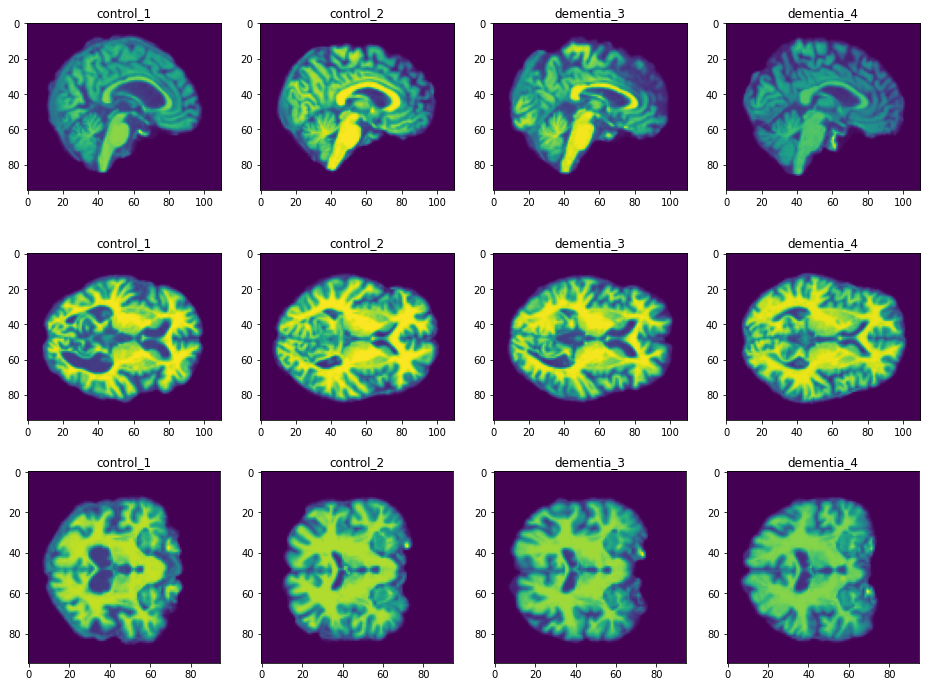

In [21]:
# Parameters for graph
nrows = 3
ncols = 4

# Set up figure and plot it
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

for i in range(4):
    sp = plt.subplot(nrows, ncols, i + 1)
#     sp.axis('Off') # Don't show axes (or gridlines)

    img = batchx[i][FLAGS.scan_width//2,:,:]
    plt.imshow(img)
    plt.title(f'control_{i+1}' if batchy[i] == 0 else f'dementia_{i+1}')
    
    sp = plt.subplot(nrows, ncols, i + 1 + 4)
#     sp.axis('Off') # Don't show axes (or gridlines)

    img = batchx[i][:,FLAGS.scan_height//2,:]
    plt.imshow(img)
    plt.title(f'control_{i+1}' if batchy[i] == 0 else f'dementia_{i+1}')
    
    sp = plt.subplot(nrows, ncols, i + 1 + 4 + 4)
    img = batchx[i][:,:,FLAGS.scan_depth//2]
    plt.imshow(img)
    plt.title(f'control_{i+1}' if batchy[i] == 0 else f'dementia_{i+1}')

In [22]:
print(batchx[0].shape)

(95, 95, 110)


In [23]:
print(FLAGS.scan_width, FLAGS.scan_height, FLAGS.scan_depth)

95 95 110


In [24]:
# delete them to save memory
del batchx, batchy, test_gen

In [25]:
training_batch_generator = MRI_Data_Generator(X_train_filenames, y_train, FLAGS.batch_size)
validation_batch_generator = MRI_Data_Generator(X_val_filenames, y_val, FLAGS.batch_size)

## CNN

In [26]:
# Model adapted from https://github.com/gfolego/alzheimers/blob/master/src/adnet.py

def create_model():
    inputs = tf.keras.Input((FLAGS.scan_width, FLAGS.scan_height, FLAGS.scan_depth, 1))
    
    # 1st block
    x = layers.Conv3D(filters=16, kernel_size=3, activation="relu", padding='same')(inputs)
    x = layers.Conv3D(filters=16, kernel_size=3, activation="relu", padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    
    # 2nd block
    x = layers.Conv3D(filters=32, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.Conv3D(filters=32, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    
    # 3rd block
    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    
    # 4th block
    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    
    # Flattern/global avg pooling
    x = layers.GlobalAveragePooling3D()(x)
    
    # FC block
    x = layers.Dense(units=128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(units=64, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    
    outputs = layers.Dense(units=1, activation="sigmoid")(x)
    
    # Define the model
    model = tf.keras.Model(inputs, outputs, name="3d-mri-cnn")
    return model

In [27]:
model = create_model()
model.summary()

Model: "3d-mri-cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 95, 95, 110, 1)]  0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 95, 95, 110, 16)   448       
_________________________________________________________________
batch_normalization (BatchNo (None, 95, 95, 110, 16)   64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 47, 47, 55, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 47, 47, 55, 32)    13856     
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 47, 47, 55, 32)    27680     
_________________________________________________________________
batch_normalization_1 (Batch (None, 47, 47, 55, 32)    1

#### Useful metrics
https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#understanding_useful_metrics

* False negatives and false positives are samples that were incorrectly classified
* True negatives and true positives are samples that were correctly classified
* Accuracy is the percentage of examples correctly classified
* Precision is the percentage of predicted positives that were correctly classified
* Recall is the percentage of actual positives that were correctly classified
* AUC refers to the Area Under the Curve of a Receiver Operating Characteristic curve (ROC-* AUC). This metric is equal to the probability that a classifier will rank a random positive sample higher than a random negative sample.
* AUPRC refers to Area Under the Curve of the Precision-Recall Curve. This metric computes precision-recall pairs for different probability thresholds.

In [28]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [29]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=METRICS)

### Set up useful callbacks/things for training model

#### Tensorboard

In [30]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/

In [31]:
from datetime import datetime
logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 profile_batch = '500,520')

In [32]:
%tensorboard --logdir=logs --port=8008

#### Set up callbacks and learning rate scheduler to avoid overfitting/underfitting

In [33]:
!rm -rf ./checkpoints/
filepath="checkpoints/model-epoch-{epoch:02d}-accuracy-{val_accuracy:.4f}-loss-{val_loss:.4f}.hdf5"
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1)

In [34]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 30)
for i in range(0, 151, 5):
    print(f'epoch {i} : {exponential_decay_fn(i):.20f}')

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

epoch 0 : 0.01000000000000000021
epoch 5 : 0.00681292069057961355
epoch 10 : 0.00464158883361277894
epoch 15 : 0.00316227766016837939
epoch 20 : 0.00215443469003188384
epoch 25 : 0.00146779926762206935
epoch 30 : 0.00100000000000000002
epoch 35 : 0.00068129206905796118
epoch 40 : 0.00046415888336127800
epoch 45 : 0.00031622776601683799
epoch 50 : 0.00021544346900318837
epoch 55 : 0.00014677992676220700
epoch 60 : 0.00010000000000000002
epoch 65 : 0.00006812920690579616
epoch 70 : 0.00004641588833612778
epoch 75 : 0.00003162277660168380
epoch 80 : 0.00002154434690031885
epoch 85 : 0.00001467799267622069
epoch 90 : 0.00001000000000000000
epoch 95 : 0.00000681292069057962
epoch 100 : 0.00000464158883361278
epoch 105 : 0.00000316227766016838
epoch 110 : 0.00000215443469003188
epoch 115 : 0.00000146779926762207
epoch 120 : 0.00000100000000000000
epoch 125 : 0.00000068129206905796
epoch 130 : 0.00000046415888336128
epoch 135 : 0.00000031622776601684
epoch 140 : 0.00000021544346900319
epoch 1

#### Create class weights, since there are less dementia samples than there are control

In [35]:
(unique, counts) = np.unique(y_labels, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)
print(f'{frequencies[0,1]/(np.sum(frequencies[:,1]))*100:.2f}% of the data is control')

[[  0 712]
 [  1 310]]
69.67% of the data is control


In [36]:
# 0 is control, 1 is dementia
control_cnt = frequencies[0,1]
dementia_cnt = frequencies[1,1]
total_cnt = control_cnt + dementia_cnt
print(control_cnt, dementia_cnt, total_cnt)

712 310 1022


In [37]:
weight_for_0 = (1 / control_cnt) * (total_cnt / 2.0)
weight_for_1 = (1 / dementia_cnt) * (total_cnt / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}
print(class_weight)

{0: 0.7176966292134831, 1: 1.6483870967741936}


In [38]:
history = model.fit(
            training_batch_generator,
            steps_per_epoch = int(X_train_filenames.shape[0] // FLAGS.batch_size),  # samples = batch_size * steps
            epochs = FLAGS.epochs,
            verbose = 1,
            validation_data = validation_batch_generator,
            validation_steps = int(X_val_filenames.shape[0] // FLAGS.batch_size),  # samples = batch_size * steps
#             callbacks = [tensorboard_cb, checkpoint_cb, early_stopping_cb, lr_scheduler],
            callbacks = [tensorboard_cb, checkpoint_cb, lr_scheduler],
            class_weight = class_weight,
            use_multiprocessing = True,
            workers = 12,
            max_queue_size = 48)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/50
102/102 [==============================] - 156s 1s/step - loss: 0.7563 - tp: 123.0000 - fp: 262.0000 - tn: 298.0000 - fn: 126.0000 - accuracy: 0.5204 - precision: 0.3195 - recall: 0.4940 - auc: 0.5232 - prc: 0.3333 - val_loss: 2.9156 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 142.0000 - val_fn: 58.0000 - val_accuracy: 0.7100 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_prc: 0.2900

Epoch 00001: saving model to checkpoints/model-epoch-01-accuracy-0.7100-loss-2.9156.hdf5
Epoch 2/50
102/102 [==============================] - 147s 1s/step - loss: 0.7030 - tp: 150.0000 - fp: 277.0000 - tn: 285.0000 - fn: 97.0000 - accuracy: 0.5377 - precision: 0.3513 - recall: 0.6073 - auc: 0.5808 - prc: 0.3754 - val_loss: 0.7033 - val_tp: 58.0000 - val_fp: 142.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accurac

### Evaluate the model

#### Plot metrics

In [45]:
def plot_metrics(history):
    
    fig = plt.gcf()
    fig.set_size_inches(20, 3 * 4)

    metrics = ['auc','accuracy','loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        lims = {'loss': {0,2}}
        name = metric.replace("_"," ").capitalize()
        sp = plt.subplot(2, 3, n + 1)
        plt.plot(history.epoch, history.history[metric], color='C0', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color='C1', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric in lims:
            plt.ylim(lims[metric])

        plt.legend()

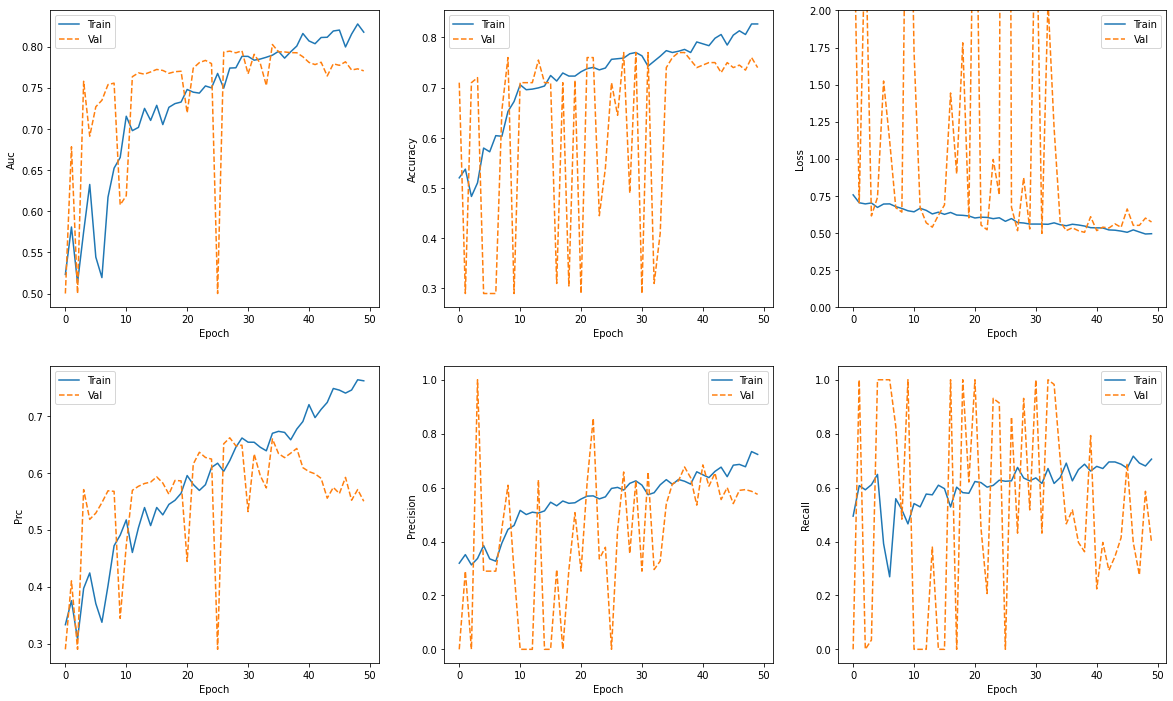

In [46]:
plot_metrics(history)

#### Save model

In [41]:
# Clear any models from previous runs
!rm -rf ./saved_model/
!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


#### Confusion Matrix

In [42]:
raw_predictions = model.predict(
    validation_batch_generator, verbose=1, max_queue_size=48,
    workers=12, use_multiprocessing=True
)

26/26 [==============================] - 34s 699ms/step


In [43]:
cm = tf.math.confusion_matrix(labels=y_val.T[0], predictions=raw_predictions.T[0])

Text(0.5, 1.0, 'Confusion matrix for validation set')

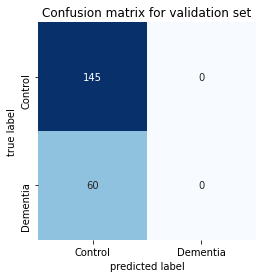

In [44]:
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=['Control', 'Dementia'],
            yticklabels=['Control', 'Dementia'])
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.title('Confusion matrix for validation set')